### **imports**

In [85]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots


### **preprocessing**

##### *pytorch model*

In [16]:
# Neural network architecture for hotel price prediction
# This network is designed to predict optimal hotel room prices based on various features
# Key design choices:
# 1. Small network (32 nodes) due to limited dataset size to prevent overfitting
# 2. Two hidden layers to capture non-linear relationships in pricing factors
# 3. Dropout (0.2) for regularization to improve generalization
# 4. ReLU activation for non-linearity while avoiding vanishing gradients
# 5. Single output node for price prediction (regression task)
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        # Smaller network since dataset appears to be relatively small (few thousand rows)
        # First hidden layer reduced from 64 to 32 nodes
        self.layer1 = nn.Linear(input_size, 32)
        # Second hidden layer also reduced to 32 nodes to prevent overfitting
        self.layer2 = nn.Linear(32, 32)
        # Output layer remains 1 node for price prediction
        self.output_layer = nn.Linear(32, 1)
        # Added dropout for regularization
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.dropout(self.relu(self.layer1(x)))
        x = self.dropout(self.relu(self.layer2(x)))
        x = self.output_layer(x)
        return x

##### *generate synthetic data*

In [72]:
def generate_hotel_data(
        num_days=365 * 3,
        total_rooms=100,
        start_date=datetime.date(2021, 1, 1),
        max_lead_time=60):
    """
    Generates more realistic synthetic hotel booking data with a wider price
    distribution and more sensitive demand.
    """
    dates = [start_date + datetime.timedelta(days=i) for i in range(num_days)]
    data = []

    # Simulate a daily base price trend to represent market fluctuations
    daily_base_prices = {}
    for check_in_date in dates:
        # Sinusoidal wave for annual seasonality + some noise
        market_seasonality = np.sin(2 * np.pi * check_in_date.timetuple().tm_yday / 365.25)
        base_price = 150 + 30 * market_seasonality
        base_price *= np.random.uniform(0.95, 1.05)  # Daily noise
        daily_base_prices[check_in_date] = base_price

    for check_in_date in dates:
        # Simulate bookings made on different days for the same check_in_date
        # Lead time: from 0 (same-day) to 60 days in advance
        for lead_time_days in range(max_lead_time):
            booking_date = check_in_date - datetime.timedelta(days=lead_time_days)

            # Start with the daily base price
            price = daily_base_prices[check_in_date]

            # Price seasonality (weekends and summer are more expensive)
            if check_in_date.weekday() >= 4:  # Friday, Saturday, Sunday
                price *= 1.25
            if 6 <= check_in_date.month <= 8:  # Summer months
                price *= 1.4

            # Add lead time adjustment: prices are slightly lower for bookings made further in advance.
            price *= 1 - 0.15 * (lead_time_days / (max_lead_time - 1.0))

            # Add significant random price fluctuation for each booking instance
            # to ensure the model sees a wide range of prices.
            price *= np.random.uniform(0.7, 1.5)
            price = max(70, price)  # Set a minimum realistic price

            # Demand is a function of price (higher price, lower demand)
            # and other factors (e.g. seasonality)
            base_demand = 45  # Increased base demand
            if check_in_date.weekday() >= 4:
                base_demand *= 1.8  # Increased weekend effect
            if 6 <= check_in_date.month <= 8:
                base_demand *= 1.6  # Increased summer effect

            # Modified lead time factor to increase bookings closer to check-in date
            # Using an exponential decay function that decreases with lead time
            lead_time_demand_factor = np.exp(-lead_time_days / 15)  # Steeper decay for early bookings
            base_demand *= (1 + 2.0 * lead_time_demand_factor)  # Boost demand more for shorter lead times

            # A more sensitive demand function, as requested
            price_sensitivity = 1.2  # Increased sensitivity
            reference_price = 120  # A lower reference price where demand is high
            demand_at_price = base_demand * np.exp(-price_sensitivity * (price - reference_price) / reference_price)
            demand_at_price = max(0, demand_at_price)

            # Simulate number of bookings based on demand
            # Add some noise
            bookings = int(np.random.poisson(demand_at_price))

            # For simplicity, we assume we can observe the "intended" number of bookings for a price
            # In a real scenario, this would be capped by available rooms.
            # The model's task is to learn this latent demand function.
            lead_time_days = check_in_date - booking_date
            lead_time_days = lead_time_days.days

            data.append(
                {
                    "booking_date": booking_date,
                    "check_in_date": check_in_date,
                    "lead_time": lead_time_days,
                    "price": price,
                    "bookings": bookings,
                }
            )

    df = pd.DataFrame(data)

    # Calculate available rooms on booking date
    # This is a simplification. A real calculation would be more complex.
    df = df.sort_values(by=["booking_date", "check_in_date"]).reset_index(drop=True)
    df["total_booked_for_check_in"] = df.groupby("check_in_date")["bookings"].cumsum()
    df["available_rooms"] = total_rooms - (df["total_booked_for_check_in"] - df["bookings"])
    df.loc[df["available_rooms"] < 0, "available_rooms"] = 0

    # Cap bookings by available rooms
    df["bookings"] = df.apply(lambda row: min(row["bookings"], row["available_rooms"]), axis=1)

    return df.drop(columns=["total_booked_for_check_in"])

total_rooms=100
max_lead_time=60
df = generate_hotel_data(total_rooms=total_rooms, max_lead_time=max_lead_time)
print(df.shape)
df.head()

(65700, 6)


,booking_date,check_in_date,lead_time,price,bookings,available_rooms
0,2020-11-03,2021-01-01,59,199.976594,31,100
1,2020-11-04,2021-01-01,58,110.478446,69,69
2,2020-11-04,2021-01-02,59,192.377553,35,100
3,2020-11-05,2021-01-01,57,143.489749,0,0
4,2020-11-05,2021-01-02,58,162.221540,55,65


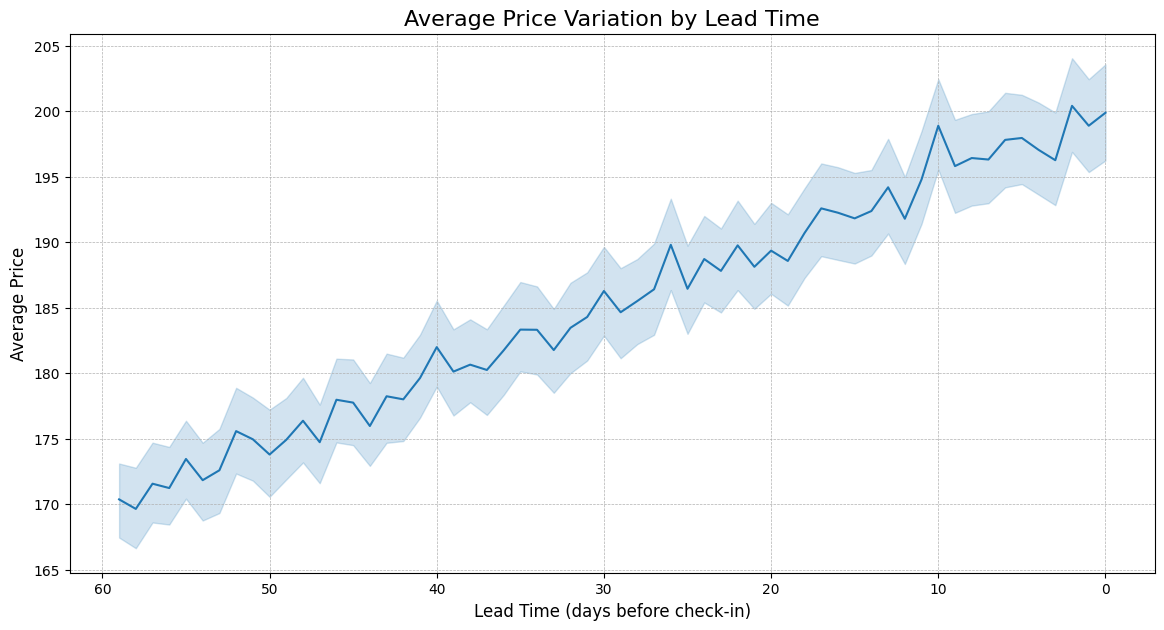

In [73]:
# Now, let's create a plot to visualize how the average price changes with the lead time.
# A line plot is a good choice here as it can show the trend clearly.
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x="lead_time", y="price", errorbar=("ci", 95))

plt.title("Average Price Variation by Lead Time", fontsize=16)
plt.xlabel("Lead Time (days before check-in)", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# It's often intuitive to see time progressing from left to right.
# By inverting the x-axis, we can see the pricing strategy as the check-in date approaches.
plt.gca().invert_xaxis()

plt.show()


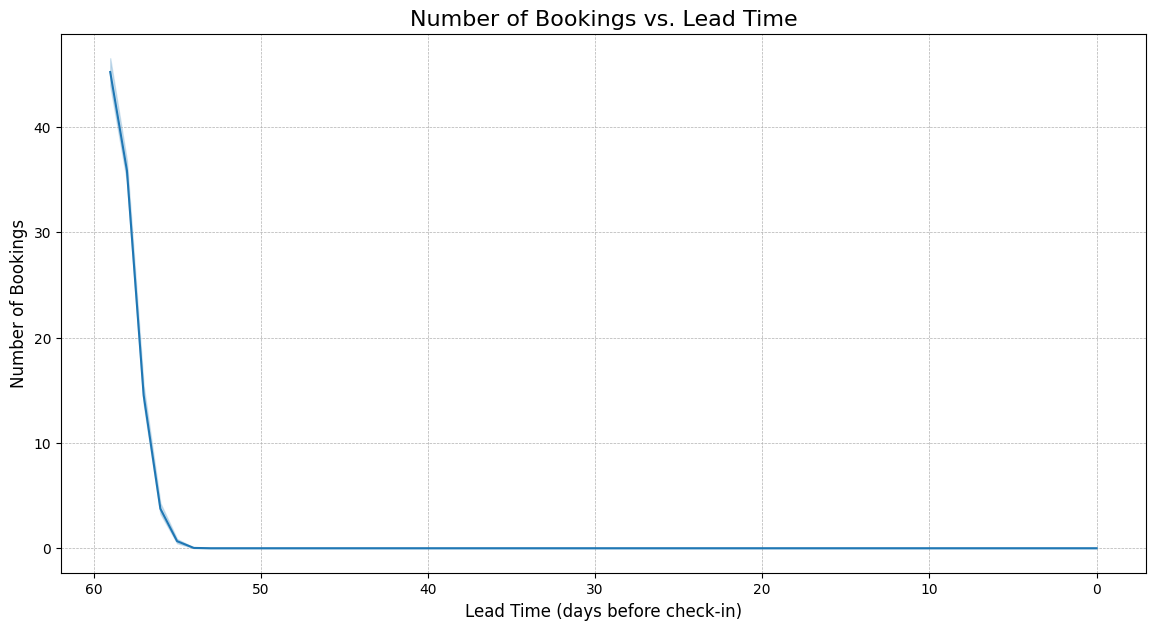

In [74]:
# Let's also visualize how the number of bookings changes with the lead time.
# This can give us insights into booking patterns.
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x="lead_time", y="bookings", errorbar=("ci", 95))

plt.title("Number of Bookings vs. Lead Time", fontsize=16)
plt.xlabel("Lead Time (days before check-in)", fontsize=12)
plt.ylabel("Number of Bookings", fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Inverting the x-axis to see the trend as the check-in date approaches.
plt.gca().invert_xaxis()

plt.show()


##### *feature engineering*

In [75]:
def feature_engineering(df):
    """
    Creates features from the raw data.
    """
    df["booking_date"] = pd.to_datetime(df["booking_date"])
    df["check_in_date"] = pd.to_datetime(df["check_in_date"])
    df["check_in_day_of_week"] = df["check_in_date"].dt.dayofweek
    df["check_in_month"] = df["check_in_date"].dt.month
    df["check_in_year"] = df["check_in_date"].dt.year

    return df

df = feature_engineering(df)
df.head()

,booking_date,check_in_date,lead_time,price,bookings,available_rooms,check_in_day_of_week,check_in_month,check_in_year
0,2020-11-03,2021-01-01,59,199.976594,31,100,4,1,2021
1,2020-11-04,2021-01-01,58,110.478446,69,69,4,1,2021
2,2020-11-04,2021-01-02,59,192.377553,35,100,5,1,2021
3,2020-11-05,2021-01-01,57,143.489749,0,0,4,1,2021
4,2020-11-05,2021-01-02,58,162.221540,55,65,5,1,2021


### **training**

##### cross validation

A Practical Note for Your Large Dataset
With millions of data points, performing full k-fold cross-validation is extremely computationally expensive. For each of the 'k' folds, you have to retrain your neural network from scratch.In scenarios with very large datasets like yours, a traditional single train/validation/test split is often sufficient and more practical. A randomly selected validation set of 10-15% of millions of records is almost certainly large and representative enough to give you a reliable estimate of performance and to detect overfitting using the Early Stopping technique we discussed earlier. Cross-validation is most critical when your dataset is small or medium-sized, where the risk of an "unlucky" split creating a non-representative validation set is much higher.


In [ ]:
#vars
features = [
    "price",
    "lead_time", 
    "check_in_day_of_week",
    "check_in_month",
    "available_rooms",
]
target = "bookings"
n_splits = 5

# Hyperparameter configurations to try
configs = [
    # Start with a baseline configuration with moderate patience
    {'lr': 0.001, 'weight_decay': 0.0, 'patience': 10, 'batch_size': 256, 'epochs': 100},
    
    # Try longer patience to ensure we're not stopping too early
    {'lr': 0.001, 'weight_decay': 0.01, 'patience': 15, 'batch_size': 256, 'epochs': 100},
    
    # Test very patient stopping to catch slow convergence
    {'lr': 0.001, 'weight_decay': 0.001, 'patience': 20, 'batch_size': 256, 'epochs': 100},
]

# --- PyTorch Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Using device: {device} ---")

# Define features and target
X = df[features].values
y = df[target].values.reshape(-1, 1)  # Reshape for PyTorch loss function

# --- K-Fold Cross-Validation for each configuration ---
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

best_config = None
best_score = float('inf')

for config in configs:
    print(f"\n=== Testing configuration: {config} ===")
    all_scores = []
    
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\n--- Fold {i+1}/{n_splits} ---")
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Scale features for this fold
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Convert to PyTorch Tensors
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

        # Create DataLoader
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

        # Build a new model for each fold
        model = Net(input_size=len(features)).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=config['lr'],
            weight_decay=config['weight_decay']
        )

        # Early stopping setup
        best_val_loss = float('inf')
        patience_counter = 0
        
        # print("Training the model for evaluation...")
        model.train()
        for epoch in range(100):  # Increased max epochs, will stop early if needed
            epoch_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                # Forward pass
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                epoch_loss += loss.item()

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Validation phase
            model.eval()
            with torch.no_grad():
                X_test_tensor = X_test_tensor.to(device)
                y_test_tensor = y_test_tensor.to(device)
                val_predictions = model(X_test_tensor)
                val_loss = criterion(val_predictions, y_test_tensor).item()
            
            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= config['patience']:
                print(f"Early stopping at epoch {epoch}")
                break
                
            model.train()

        # print(f"Fold {i+1} Loss (MSE): {best_val_loss}")
        all_scores.append(best_val_loss)

    avg_score = np.mean(all_scores)
    print("\n--- Configuration Summary ---")
    print(f"Average Loss (MSE): {avg_score:.4f}")
    print(f"Standard Deviation: {np.std(all_scores):.4f}")
    
    if avg_score < best_score:
        best_score = avg_score
        best_config = config

print("\n=== Final Results ===")
print(f"Best configuration: {best_config}")
print(f"Best average MSE: {best_score:.4f}")

--- Using device: cpu ---

=== Testing configuration: {'lr': 0.001, 'weight_decay': 0.0, 'patience': 10, 'batch_size': 256, 'epochs': 100} ===

--- Fold 1/5 ---

--- Fold 2/5 ---

--- Fold 3/5 ---

--- Fold 4/5 ---

--- Fold 5/5 ---

--- Configuration Summary ---
Average Loss (MSE): 1.5574
Standard Deviation: 0.0983

=== Testing configuration: {'lr': 0.001, 'weight_decay': 0.01, 'patience': 15, 'batch_size': 256, 'epochs': 100} ===

--- Fold 1/5 ---

--- Fold 2/5 ---

--- Fold 3/5 ---

--- Fold 4/5 ---

--- Fold 5/5 ---

--- Configuration Summary ---
Average Loss (MSE): 2.1841
Standard Deviation: 0.2225

=== Testing configuration: {'lr': 0.001, 'weight_decay': 0.001, 'patience': 20, 'batch_size': 256, 'epochs': 100} ===

--- Fold 1/5 ---

--- Fold 2/5 ---

--- Fold 3/5 ---

--- Fold 4/5 ---

--- Fold 5/5 ---

--- Configuration Summary ---
Average Loss (MSE): 1.6300
Standard Deviation: 0.2045

=== Final Results ===
Best configuration: {'lr': 0.001, 'weight_decay': 0.0, 'patience': 10, '

##### training the best model over the whole dataset

In [79]:
best_config = {'lr': 0.001, 'weight_decay': 0.0, 'patience': 10, 'batch_size': 256, 'epochs': 100}

In [120]:
# --- Final Model Training on Full Dataset ---
# The loss in this code represents the Mean Squared Error (MSE) between predicted and actual values
# MSE measures how far off our price predictions are from the true prices by:
# 1. Taking the difference between predicted and actual prices
# 2. Squaring these differences (to make all values positive and penalize larger errors more)
# 3. Taking the average across all predictions
# A lower MSE means our model is making more accurate price predictions
print("\n--- Training Final Model on Entire Dataset ---")

# 1. Create and fit the final scaler on all data
final_scaler = StandardScaler()
X_scaled = final_scaler.fit_transform(X)

# 2. Convert full dataset to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# 3. DataLoader for final training
full_dataset = TensorDataset(X_tensor, y_tensor)
full_loader = DataLoader(full_dataset, batch_size=best_config['batch_size'], shuffle=True)

# 4. Create the final model
final_model = Net(input_size=len(features)).to(device)
criterion = nn.MSELoss()  # Mean Squared Error loss function
optimizer = torch.optim.Adam(final_model.parameters(), 
                           lr=best_config['lr'],
                           weight_decay=best_config['weight_decay'])

# 5. Train the final model on all data
final_model.train()
best_loss = float('inf')  # Track best (lowest) MSE seen so far
patience_counter = 0
loss_history = []  # Track loss values for plotting

for epoch in range(best_config['epochs']):
    epoch_loss = 0  # Accumulate MSE across all batches in epoch
    for i, (batch_X, batch_y) in enumerate(full_loader):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # Forward pass - get predictions and compute MSE
        outputs = final_model(batch_X)
        loss = criterion(outputs, batch_y)  # Calculate MSE for this batch
        epoch_loss += loss.item()

        # Backward and optimize - update model to reduce MSE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calculate average MSE across all batches
    avg_loss = epoch_loss/len(full_loader)
    loss_history.append(avg_loss)  # Store loss for plotting
    
    # Early stopping - if MSE stops improving, prevent overfitting
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1
        
    if patience_counter >= best_config['patience']:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{best_config['epochs']}], Loss (MSE): {avg_loss:.4f}")

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(range(1, len(loss_history) + 1)),
    y=loss_history,
    mode='lines',
    name='Training Loss'
))

fig.update_layout(
    title='Training Loss Over Time',
    xaxis_title='Epoch',
    yaxis_title='Loss (MSE)',
    showlegend=True,
    width=1000,
    height=400
)

fig.show()


--- Training Final Model on Entire Dataset ---
Epoch [10/100], Loss (MSE): 3.3052
Epoch [20/100], Loss (MSE): 2.7153
Epoch [30/100], Loss (MSE): 2.2871
Epoch [40/100], Loss (MSE): 2.0098
Epoch [50/100], Loss (MSE): 1.9168
Epoch [60/100], Loss (MSE): 1.8465
Epoch [70/100], Loss (MSE): 1.7727
Epoch [80/100], Loss (MSE): 1.6468
Epoch [90/100], Loss (MSE): 1.5715
Epoch [100/100], Loss (MSE): 1.5053


##### plot demand revenue curve

In [121]:
# --- Revenue Optimization (using the final model) ---
def predict_demand(price, lead_time, check_in_date, available_rooms, model, scaler, device):
    check_in_date = pd.to_datetime(check_in_date)
    day_of_week = check_in_date.dayofweek
    month = check_in_date.month

    input_df = pd.DataFrame(
        {
            "price": [price],
            "lead_time": [lead_time],
            "check_in_day_of_week": [day_of_week],
            "check_in_month": [month],
            "available_rooms": [available_rooms],
        }
    )

    # Ensure column order is the same
    input_df = input_df[features]

    input_scaled = scaler.transform(input_df.values)

    # Convert to tensor and send to device
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(device)

    # Prediction
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        predicted_bookings = model(input_tensor).item()

    return max(0, predicted_bookings)

In [122]:
def plot_demand_revenue_curve(date_str, lead_time, available_rooms, model, scaler, device):
    # We generate 100 prices from $50 to $500 to see how demand and revenue change.
    prices = np.linspace(50, 500, 100)
    demands = [predict_demand(p, lead_time, date_str, available_rooms, model, scaler, device) for p in prices]
    revenues = [p * d for p, d in zip(prices, demands)]

    optimal_price_index = np.argmax(revenues)
    optimal_price = prices[optimal_price_index]
    max_revenue = revenues[optimal_price_index]

    # Create subplots
    fig = make_subplots(
        rows=1, cols=2, subplot_titles=[f"Demand Curve for {date_str}", f"Revenue Curve for {date_str}"]
    )

    # Plot Demand Curve
    fig.add_trace(go.Scatter(x=prices, y=demands, name="Demand"), row=1, col=1)

    # Plot Revenue Curve
    fig.add_trace(go.Scatter(x=prices, y=revenues, name="Revenue"), row=1, col=2)

    # Add vertical line for optimal price
    fig.add_vline(
        x=optimal_price,
        line_dash="dash",
        line_color="red",
        row=1,
        col=2,
        annotation_text=f"Optimal Price: ${optimal_price:.2f}<br>Max Revenue: ${max_revenue:.2f}",
        annotation_position="top right",
    )

    # Update layout
    fig.update_layout(showlegend=True, width=1000, height=400)

    # Update axes labels
    fig.update_xaxes(title_text="Price ($)", row=1, col=1)
    fig.update_xaxes(title_text="Price ($)", row=1, col=2)
    fig.update_yaxes(title_text="Predicted Bookings", row=1, col=1)
    fig.update_yaxes(title_text="Predicted Revenue ($)", row=1, col=2)

    fig.show()


In [142]:
# Example: Find the optimal price for a weekend in the summer
print("\n--- Optimizing Revenue for a Specific Day ---")
plot_demand_revenue_curve(
    date_str="2024-07-26",  # A Friday in summer
    lead_time=10,  # 30 days in advance
    available_rooms=60,  # 80 rooms available
    model=final_model,
    scaler=final_scaler,
    device=device,
)


--- Optimizing Revenue for a Specific Day ---


### **reinforcement learning agent**

The model is also trained. final_model

##### Reinforcement Learning Environment definition

This class will simulate the booking process for a single check-in date. The RL agent will interact with this environment by setting prices, and the environment will use your trained model to predict how many bookings are made at that price, returning the resulting revenue as a reward.

In [138]:
class HotelBookingEnv:
    def __init__(self, demand_model, X_scaler, total_rooms=100, max_lead_time=59):
        self.demand_model = demand_model
        self.X_scaler = X_scaler  # We only need the one scaler for inputs
        self.total_rooms = total_rooms
        self.max_lead_time = max_lead_time

        self.action_space = np.linspace(100, 500, 20)
        self.num_actions = len(self.action_space)

    def _predict_bookings(self, state, action):
        price = self.action_space[action]
        lead_time_days, available_rooms, day_of_week, month, _ = state

        if available_rooms <= 0:
            return 0

        # Create input array with 5 features
        input_features = np.array([[price, lead_time_days, available_rooms, day_of_week, month]])

        # Scale inputs using the single scaler
        input_scaled = self.X_scaler.transform(input_features)
        input_tensor = torch.tensor(input_scaled, dtype=torch.float32)

        with torch.no_grad():
            # Get the direct, unscaled prediction from the model
            predicted_bookings = self.demand_model(input_tensor).item()

        # No y_scaler needed. Just ensure the value is a valid number of bookings.
        num_bookings = min(available_rooms, max(0, int(predicted_bookings)))
        return num_bookings

    def reset(self, check_in_date=None):
        if check_in_date is None:
            self.check_in_date = pd.to_datetime(df["check_in_date"].sample(1).iloc[0])
        else:
            self.check_in_date = pd.to_datetime(check_in_date)

        self.lead_time = self.max_lead_time
        self.available_rooms = self.total_rooms

        self.state = [
            self.lead_time,
            self.available_rooms,
            self.check_in_date.dayofweek,
            self.check_in_date.month,
            self.check_in_date.year,
        ]
        return self.state

    def step(self, action):
        num_bookings = self._predict_bookings(self.state, action)
        price = self.action_space[action]
        reward = price * num_bookings

        self.available_rooms -= num_bookings
        self.lead_time -= 1
        self.state = [
            self.lead_time,
            self.available_rooms,
            self.check_in_date.dayofweek,
            self.check_in_date.month,
            self.check_in_date.year,
        ]

        done = self.lead_time < 0 or self.available_rooms <= 0
        return self.state, reward, done, {}

##### QLearningAgent definition

This agent will learn the optimal pricing strategy by interacting with the HotelBookingEnv you just created.
It uses a Q-table to map states (specifically, how many days are left to book and how many rooms are available) to the expected long-term revenue of each possible pricing action.

In [139]:
class QLearningAgent:
    def __init__(
        self,
        num_actions,
        total_rooms,
        max_lead_time,
        learning_rate=0.1,
        discount_factor=0.99,
        epsilon=1.0,
        epsilon_decay=0.999,
        epsilon_min=0.01,
    ):
        self.num_actions = num_actions
        self.total_rooms = total_rooms  # Store total_rooms
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.room_bins = 10
        self.q_table = np.zeros((max_lead_time + 1, self.room_bins, num_actions))

    def _discretize_state(self, state):
        lead_time, available_rooms, _, _, _ = state
        # Convert continuous available_rooms into discrete bins
        room_index = int(available_rooms / (self.total_rooms / self.room_bins))
        room_index = min(self.room_bins - 1, max(0, room_index))
        return (int(lead_time), room_index)

    def choose_action(self, state):
        discrete_state = self._discretize_state(state)
        # Epsilon-greedy strategy
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        else:
            return np.argmax(self.q_table[discrete_state])

    def update(self, state, action, reward, next_state, done):
        discrete_state = self._discretize_state(state)
        discrete_next_state = self._discretize_state(next_state)

        old_value = self.q_table[discrete_state][action]
        next_max = 0 if done else np.max(self.q_table[discrete_next_state])

        new_value = old_value + self.lr * (reward + self.gamma * next_max - old_value)
        self.q_table[discrete_state][action] = new_value

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

##### training QLearningAgent

In [140]:
# --- Train the RL Agent (with single scaler) ---

# Make sure 'final_model' and 'final_scaler' are from your training cell
# The environment now only takes X_scaler (which is your final_scaler)
env = HotelBookingEnv(
    demand_model=final_model, 
    X_scaler=final_scaler,  # Pass your single scaler here
    total_rooms=total_rooms, 
    max_lead_time=max_lead_time - 1
)

# The QLearningAgent class does not need changes, just initialize it
agent = QLearningAgent(
    num_actions=env.num_actions, 
    total_rooms=total_rooms, 
    max_lead_time=max_lead_time
)

episodes = 5000
total_rewards = []

print("\n--- Training Reinforcement Learning Agent ---")
for episode in range(episodes):
    state = env.reset()
    done = False
    episode_reward = 0

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward

    total_rewards.append(episode_reward)

    if (episode + 1) % 500 == 0:
        avg_reward = np.mean(total_rewards[-500:])
        print(f"Episode {episode + 1}/{episodes}, Average Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.2f}")




--- Training Reinforcement Learning Agent ---
Episode 500/5000, Average Reward: 0.00, Epsilon: 0.01
Episode 1000/5000, Average Reward: 0.00, Epsilon: 0.01
Episode 1500/5000, Average Reward: 0.00, Epsilon: 0.01
Episode 2000/5000, Average Reward: 0.00, Epsilon: 0.01
Episode 2500/5000, Average Reward: 0.00, Epsilon: 0.01
Episode 3000/5000, Average Reward: 0.00, Epsilon: 0.01
Episode 3500/5000, Average Reward: 0.00, Epsilon: 0.01
Episode 4000/5000, Average Reward: 0.00, Epsilon: 0.01
Episode 4500/5000, Average Reward: 0.00, Epsilon: 0.01
Episode 5000/5000, Average Reward: 0.00, Epsilon: 0.01


In [141]:
# --- Compare RL Agent vs. Baseline Strategy ---

# Set the trained agent to exploitation mode (no more random actions)
agent.epsilon = 0

def run_simulation(env, policy, check_in_date):
    """Runs one full simulation for a given check-in date and policy."""
    state = env.reset(check_in_date=check_in_date)
    done = False
    total_revenue = 0
    while not done:
        action = policy(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_revenue += reward
    return total_revenue

# Define the two policies to compare

def rl_policy(state):
    """The policy learned by our Q-learning agent."""
    return agent.choose_action(state)

def baseline_greedy_policy(state):
    """A greedy policy that chooses the price with the highest *immediate* revenue."""
    best_action = -1
    max_revenue = -1
    # Check every possible price to see which one gives the best immediate reward
    for action in range(env.num_actions):
        price = env.action_space[action]
        # Use the environment's internal prediction function
        bookings = env._predict_bookings(state, action)
        revenue = price * bookings
        if revenue > max_revenue:
            max_revenue = revenue
            best_action = action
    return best_action

# --- Run the Comparison ---
# Use the last 20 unique dates from the dataset as a held-out test set
test_dates = df['check_in_date'].unique()[-20:]

rl_revenues = []
baseline_revenues = []

# Make sure to use the correct single scaler ('final_scaler' or whatever you named it)
env = HotelBookingEnv(
    demand_model=final_model, 
    X_scaler=final_scaler, 
    total_rooms=total_rooms, 
    max_lead_time=max_lead_time - 1
)

print('\n--- Running Final Comparison Simulations ---')
for date in test_dates:
    # Run a simulation for each policy on the same date
    rl_revenue = run_simulation(env, rl_policy, date)
    baseline_revenue = run_simulation(env, baseline_greedy_policy, date)
    
    rl_revenues.append(rl_revenue)
    baseline_revenues.append(baseline_revenue)

# --- Report Results ---
avg_rl_revenue = np.mean(rl_revenues)
avg_baseline_revenue = np.mean(baseline_revenues)

print(f'\nAverage RL Agent Revenue: ${avg_rl_revenue:,.2f}')
print(f'Average Baseline (Greedy) Revenue: ${avg_baseline_revenue:,.2f}')

if avg_baseline_revenue > 0:
    improvement = (avg_rl_revenue - avg_baseline_revenue) / avg_baseline_revenue * 100
    print(f'Improvement: {improvement:.2f}%')
else:
    print("Baseline revenue was zero, cannot calculate improvement.")



--- Running Final Comparison Simulations ---

Average RL Agent Revenue: $0.00
Average Baseline (Greedy) Revenue: $0.00
Baseline revenue was zero, cannot calculate improvement.
